# Algorithme de Descente et parachutage
Ce notebook Jupyter permet d'exécuter l'algorithme génétique générationnel hybridé sur une population initiale d'individus générée aléatoirement.

Les exemples sont donnés sur la grande instance.

In [2]:
# Necessary imports
import pandas as pandas
import os
import matplotlib.pyplot as plt
import random as rd #for the random solution generator.
import time #for time and complexity measures

# Data needed
df_Tableau_Rangs = pandas.read_excel(os.path.abspath('Tableau_rangs2.xlsx/'), index_col = 0).stack() #Tableau_Rangs est calculé grâce à la fonction donnée avec le code AMPL, "creation_Tableau_Rangs".
df_distances = pandas.read_excel(os.path.abspath('Distances2.xlsx/'), index_col = 0).stack()

df_Vente = pandas.read_csv(os.path.abspath('Vente2.txt'))
df_Vente.set_index("Produits", inplace = True)

On définit d'abord des fonctions nécessaires à la méthode (notamment la fonction cout_total, très importante car calcule le coût d'une solution donnée):

In [3]:
def cout_total(repartition, distances, Tableau_Rangs, df_ventes): #repartition est le dictionnaire de repartition des machines
    Tableau_Rangs = Tableau_Rangs.unstack()
    distances = distances.unstack()
    #les donnees d'origine sont .stack, donc je les .unstack pour pouvoir les utiliser.
    
    
    nb_produits = Tableau_Rangs.shape[0] #nb de lignes = nb_produits
    nb_mach_util = Tableau_Rangs.shape[1] #nb de machines rencontrées
    nb_mach = distances.shape[0] - 2
    nb_empl = len(repartition)
    
    #definition du dict repartition_emplacements à partir du dict repartition: "réciproque" de ce dernier.
    repartition_emplacements = dict()
    for i in range(nb_mach):
        repartition_emplacements[repartition[i+1]] = i+1 #la machine à l'emplacement i+1 est... à l'emplacement i+1.
    #permet d'acceder à l'emplacement de chaque machine ! Pratique pour la suite.
    
    #On peut finalement commencer a calculer ledit coût final.
    cout = 0
    for p in range(nb_produits):
        for l in range(nb_mach_util-1):
            j1 = repartition_emplacements[Tableau_Rangs.iloc[p,l]] #emplacement de la machine de départ
            j2 = repartition_emplacements[Tableau_Rangs.iloc[p,l+1]]#emplacement de la machine d'arrivee
            cout += df_ventes.iloc[p,0] * distances.iloc[j1,j2] #on distribue le facteur 'vente[produit]'.
            
        #on a rajoute l'entrée et la sortie:
        premier = repartition_emplacements[Tableau_Rangs.iloc[p,0]]
        dernier = repartition_emplacements[Tableau_Rangs.iloc[p,-1]]
        cout += df_ventes.iloc[p,0] *  distances.iloc[0,premier] #entree 
        cout += df_ventes.iloc[p,0] * distances.iloc[dernier,10] #+ sortie
        
    return cout

In [4]:
def random_solution_generator(nb_solutions, nb_machines = 9, nb_emplacements = 9):
    idiot_solution = [i for i in range(1, nb_machines+1)] #les machines sont numérotées de 1 à 9, pas de 0 à 8.
    sol_list = []
    for i in range(nb_solutions):
        rd.shuffle(idiot_solution)
        new_solution = dict()
        for i in range(nb_machines):
            new_solution[i+1] = idiot_solution[i] #la machine à l'emplacement i. On transforme juste la liste en dictionnaire.
        sol_list.append(new_solution)
    
    return sol_list

## Elaboration des diverses méthodes de l'algorithme génétique
Les cellules suivantes définissent respectivement les opérations de:
- Sélection (par tournoi binaire)
- croisement (1X adapté)
- mutation (hybridée par méthode de descente)
- remplacement d'individus d'une population
    - insertion (en conservant l'ordre des coûts dans la population)

In [5]:
def binary_tournament_selector(population, population_size):
    """
    Binary tournament to select two parents inside the population.
    population: list of length population_size containing each solution (population)
    population_size: needed to randomly pick two parents within the given population.
    population = liste de couples -> ajout d'un [1] à chaque fois pour bien récupérer la solution en question.
    """
    
    parents = [] #list that will eventually contain the 2 selected parents ( as well as their cost )
    
    for i in range(2): #2 iterations of the method (one per parent)
        
        #on tire au hasard deux indices de la liste "population":
        i1,i2 = rd.randint(0, population_size-1), rd.randint(0, population_size-1)
        #on récupère les parents associés
        cout1, parent1 = population[i1]
        cout2, parent2 = population[i2]

        if cout1 < cout2:
            parents.append((cout1, parent1))
        else: 
            parents.append((cout2, parent2))
        
        
        if i == 1:
            while (parent1 == parents[0][1]) or (parent2 == parents[0][1]): #pour ne pas ajouter le même parent deux fois d'affilée !! On évite l'auto-reproduction.

                #on tire au hasard deux indices de la liste "population":
                i1,i2 = rd.randint(0, population_size-1), rd.randint(0, population_size-1)
                #on récupère les parents associés
                cout1, parent1 = population[i1]
                cout2, parent2 = population[i2]

            if cout1 < cout2: #on ajoute le meilleur parent
                parents.append((cout1, parent1))
            else: 
                parents.append((cout2, parent2))
    
            
    return (parents[0][1], parents[1][1])

In [6]:
def croisement(parent1, parent2, nb_mach):
    """
    Réalise le croisement entre deux parents.
    On a besoin de nb_mach pour pouvoir tirer un entier aléatoire correct pour la coupure 
    (définition aléatoire du point de coupure - random.randint, pris dans le range du nombre de machines).
    """
    
    coupure = rd.randint(1, nb_mach) #ça laisse la possibilité de ne rien croiser du tout... si coupure = nb_mach
    
    enfant = dict()
    
    #on recopie les caractéristiques du parent1 jusqu'à juste avant la coupure
    for i in range(1, coupure):
        enfant[i] = parent1[i]
        
    #il faut remplir la suite en faisant attention à garder une solution viable (pas de machine affectée à deux emplacements)
    k = coupure #pour avoir un indice correct pour l'enfant, alors qu'on parcourt le parent1 dès le départ.
    already_affected = [parent1[j] for j in range(1, coupure)]
    for i in range(1, nb_mach+1): #nb_mach + 1 puisque décalage d'indice etc, as usual
        
        if parent2[i] not in already_affected:
            #on ajoute le parent2 que si la machine n'est pas déjà affectée par le parent1
            enfant[k] = parent2[i]
            k+=1
    
    return enfant

In [7]:
def mutation(enfant, df_distances, df_Tableau_Rangs, df_Vente, nb_mach):
    """
    Cette fonction est appelée aléatoirement dans le corps principal du code.
    Réalise une mutation aléatoire à partir d'un enfant donné, passé en paramètre. Hybridation avec une itération de la méthode de descente (recherche locale)
    """
    
    #recopie d'une itération de l'heuristique "méthode de la plus forte pente" pour choisir un "bon" voisin:
    cout = cout_total(enfant, df_distances, df_Tableau_Rangs, df_Vente)
    
    for i1 in range(1, nb_mach+1): #indices décalés car dictionnaire 1->nb_mach
            for i2 in range(1, nb_mach+1):
                voisin = enfant.copy()
                voisin[i1], voisin[i2] = voisin[i2], voisin[i1]
                cout_suivant = cout_total(voisin, df_distances, df_Tableau_Rangs, df_Vente) #on calcule le coût associé 
                if cout_suivant < cout: #on s'arrete des qu'on trouve un meilleur voisin
                    break
            if cout_suivant < cout: #on s'arrete des qu'on trouve un meilleur voisin
                    break
                    
    return voisin

In [8]:
def remplacement(population, population_size, enfant, df_distances, df_Tableau_Rangs, df_Vente):
    """
    Version générationnelle. Voir plus loin pour la version incrémentale.
    """    
    
    cout_enfant = cout_total(enfant, df_distances, df_Tableau_Rangs, df_Vente)
    
    cout_max = population[-1][0] #premier element du couple = coût de la solution. liste triée du plus petit au plus grand coût.
    
    if cout_enfant not in [population[k][0] for k in range(population_size)]: #EVITER D'AJOUTER UN DOUBLON (au moins de coût...)
        if cout_enfant < cout_max: #si l'enfant est meilleur que le moins bon élément de la population, on remplace !
            population = insertion(enfant, cout_enfant, population, population_size) #on insère l'enfant EN GARDANT L'ORDRE TRIE !! complexité améliorée - on ne recalcule pas TOUS les coûts à chaque fois.
            
            #dans le mode générationnel, on ne met à jour la population qu'à la fin d'une génération.

    return population

In [9]:
def insertion(enfant, cout_enfant, population, population_size):
    """
    Population_size en paramètre permet d'éviter d'avoir à calculer un len() à chaque appel à "insertion()". C'est du "pinaillage" pour gagner en complexité.
    """ 
    k = 0
    while (k < population_size) and (cout_enfant > population[k][0]): #pour insérer l'enfant au bon endroit
        k += 1
        
    population.insert(k, (cout_enfant, enfant))
    #https://apprendrepython.com/ajouter-un-element-a-une-liste-en-python-append-extend-insert/
    
    return population

## Fonctions spécifiques (hors algorithme *générationnel* et *hybride*)
Pour les différentes versions de l'algorithme, j'ai défini diverses fonctions.
Les cellules de code suivantes implémentent ainsi une mutation complètement aléatoire pour pouvoir différencier la méthode hybridée de celle non hybridée.

In [10]:
def random_mutation(enfant, df_distances, df_Tableau_Rangs, df_Vente, nb_mach):
    """
    Cette fonction est appelée aléatoirement dans le corps principal du code.
    Réalise une mutation aléatoire à partir d'un enfant donné, passé en paramètre. 
    PAS d'hybridation.
    """

    i1 = rd.randint(1,nb_mach)
    i2 = rd.randint(1,nb_mach)
    while i2 == i1: #il faut que i1 != i2 pour qu'il y ait mutation
        i2 = rd.randint(1,nb_mach)
    
    enfant[i1], enfant[i2] = enfant[i2], enfant[i1]
                    
    return enfant

In [11]:
def remplacement_incremental(population, population_size, enfant, df_distances, df_Tableau_Rangs, df_Vente):
    """
    version incrémentale du remplacement d'un individu par un enfant
    """    
    
    cout_enfant = cout_total(enfant, df_distances, df_Tableau_Rangs, df_Vente)
    
    cout_max = population[-1][0] #premier element du couple = coût de la solution. liste triée du plus petit au plus grand coût.
    
    if cout_enfant not in [population[k][0] for k in range(population_size)]: #EVITER D'AJOUTER UN DOUBLON (au moins de coût...)
        if cout_enfant < cout_max: #si l'enfant est meilleur que le moins bon élément de la population, on remplace !
            population = insertion(enfant, cout_enfant, population, population_size) #on insère l'enfant EN GARDANT L'ORDRE TRIE !! complexité améliorée - on ne recalcule pas TOUS les coûts à chaque fois.
            
            individu_remplace = rd.randint(-15, -1)
            population.pop(individu_remplace) #on retire un des derniers élts: préserver la variabilité !!

    return population

## Fonction principale
Les cellules de code suivantes définissent les différentes versions implémentées de l'algorithme génétique:
- version **incrémentale**
- version **générationnelle**
- version **générationnelle *hybride*** (avec méthode de descente)

In [12]:
def sort_func(x):
    """
    pour trier sur le 1er elt (à savoir le coût, dans notre cas).
    utilisé dans la fonction générale de l'algorithme génétique, car notre population est en fait
    une liste de *couples* coût, individu (pour économiser le calcul du coût à chaque étape).
    """
    
    return x[0] #on renvoie le premier élément du couple, qui sera le coût dans notre cas.

In [13]:
## Version incrémentale
def genetic_algorithm_incremental(population_size, mutation_proba, df_distances, df_Tableau_Rangs, df_Vente, nb_mach, max_iter = 500):
    """
    population size of your choice.
    mutation_proba: gives the probability, for each child, to get a mutation ( 0.01 < x < 0.2)
    nb_mach = nb de machines (réelles comme virtuelles)
    df_distances, df_Tableau_Rangs, df_Vente: données spécifiques à notre problème.

    Renvoie les 10 premières meilleures solutions de la popuplation, leur coût, ainsi que la liste d'amélioration du meilleur coût au fur et à mesure de l'algorithme.

    """
    
    
    #create random beginning population
    population = random_solution_generator(population_size, nb_mach)
    
    
    population = [ (cout_total(ind,df_distances, df_Tableau_Rangs, df_Vente), ind) for ind in population ]
    population.sort(key = sort_func) #on utilise sort_func définie au préalable
    
    #population = liste de couples pour pouvoir garder une liste de population triée et éviter une complexité importante,
    #du fait du calcul du coût à chaque étape pour toute la population.
    
    couts_initiaux = [population[i][0] for i in range(population_size)] #pour calcul de l'amélioration à la fin

    
    best_cost = population[0][0]
    best_sol = population[0][1]
    
    best_costs_list = [best_cost] #liste d'amélioration des meilleurs coûts trouvés jusqu'ici.
    
    
    nb_iter = 0 #counter of nb of iterations.
    while nb_iter < max_iter:
    
        #version INCREMENTALE - 1 enfant à la fois - + grd nb d'itérations (!= générationnelle)
        parent1, parent2 = binary_tournament_selector(population, population_size)
        enfant = croisement(parent1, parent2, nb_mach)

        if rd.random() < mutation_proba:
            enfant = random_mutation(enfant, df_distances, df_Tableau_Rangs, df_Vente, nb_mach) #méthode hybride: mutation avec 1 itération de la méthode de la plus forte pente

        #replace the least fit individuals by those more fit (meilleur valeur de la fonction objectif)
        population = remplacement_incremental(population, population_size, enfant, df_distances, df_Tableau_Rangs, df_Vente)
        
        #on met à jour best_sol si on trouve mieux
        new_best_cost = population[0][0]
        if new_best_cost < best_cost:
            best_sol, best_cost = population[0][1], population[0][0]
        best_costs_list.append(best_cost) #on le fait en dehors de la boucle pour pouvoir bien voir la progression A CHAQUE ETAPE de l'algorithme.
    
        nb_iter += 1
        
    ten_first_best_sol, ten_first_best_cost = [], []
    for i in range(10): #on récupère les 10 meilleurs et leurs coûts
        ten_first_best_sol.append(population[i][1])
        ten_first_best_cost.append(population[i][0])
        
    #calcul de l'amélioration moyenne (pour affichage dans le graphique et comparaison entre les méthodes)
    amelioration_des_couts = [(population[i][0] / couts_initiaux[i])*100 for i in range(population_size)]
    amelioration_moyenne = 100 - round(sum(amelioration_des_couts) / population_size)
    
    #returns the 10 best solution found and their cost, as well as the progression list of the best cost.
    return ten_first_best_sol, ten_first_best_cost, best_costs_list, amelioration_moyenne

In [14]:
def genetic_algorithm_generation(population_size, mutation_proba, df_distances, df_Tableau_Rangs, df_Vente, nb_mach, max_iter = 15):
    """
    population size of your choice.
    mutation_proba: gives the probability, for each child, to get a mutation ( 0.01 < x < 0.2)
    nb_mach = nb de machines (réelles comme virtuelles)
    df_distances, df_Tableau_Rangs, df_Vente: données spécifiques à notre problème.

    Renvoie les 10 premières meilleures solutions de la popuplation, leur coût, ainsi que la liste d'amélioration du meilleur coût au fur et à mesure de l'algorithme.
    """
    
    
    #create random beginning population
    population = random_solution_generator(population_size, nb_mach)
    
    
    population = [ (cout_total(ind,df_distances, df_Tableau_Rangs, df_Vente), ind) for ind in population ]
    population.sort(key = sort_func)

    couts_initiaux = [population[i][0] for i in range(population_size)] #pour calcul de l'amélioration à la fin
    
    
    #population = liste de couples pour pouvoir garder une liste de population triée et éviter une complexité importante
    #du fait du calcul du coût à chaque étape pour toute la population.
    
    best_cost = population[0][0]
    best_sol = population[0][1]
    
    best_costs_list = [best_cost] #liste d'amélioration des meilleurs coûts trouvés jusqu'ici.
    
    
    nb_iter = 0 #counter of nb of iterations.
    while nb_iter < max_iter:
    
        #version GENERATIONNELLE
        parents_list = []
        enfants_list = []
        for l in range(population_size//2):
            parent1, parent2 = binary_tournament_selector(population, population_size) #1 parent peut être sélectionné plusieurs fois ! C'est plutôt comme ça que ça marche dans la nature.
            parents_list.append( (parent1,parent2) )
            
            enfant = croisement(parent1, parent2, nb_mach)
            enfants_list.append(enfant)

            if rd.random() < mutation_proba:
                enfant = random_mutation(enfant, df_distances, df_Tableau_Rangs, df_Vente, nb_mach) #méthode hybride: mutation avec 1 itération de la méthode de la plus forte pente
            
            #population size ne grandit QUE si on rajoute bel et bien l'enfant. On doit utiliser len(population), cette fois-ci (pas possible d'appeler avec population_size + k)
            population = remplacement(population, len(population), enfant, df_distances, df_Tableau_Rangs, df_Vente) 
                
        #on ne garde que les meilleurs !
        population = population[:population_size] #... en gardant une population constante.

        #on met à jour best_sol si on trouve mieux
        new_best_cost = population[0][0] #car la liste de population est triée par coûts descendants
        if new_best_cost < best_cost:
            best_sol, best_cost = population[0][1], population[0][0]
        best_costs_list.append(best_cost) #on le fait en dehors de la boucle pour pouvoir bien voir la progression A CHAQUE ETAPE de l'algorithme.
    
        nb_iter += 1
    

    ten_first_best_sol, ten_first_best_cost = [], []
    for i in range(10): #on récupère les 10 meilleurs et leurs coûts
        ten_first_best_sol.append(population[i][1])
        ten_first_best_cost.append(population[i][0])
    
    #calcul de l'amélioration moyenne (pour affichage dans le graphique et comparaison entre les méthodes)
    amelioration_des_couts = [(population[i][0] / couts_initiaux[i])*100 for i in range(population_size)]
    amelioration_moyenne = 100 - round(sum(amelioration_des_couts) / population_size)


    #returns the 10 best solution found and their cost, as well as the progression list of the best cost and the mean amelioration of the first solutions.
    return ten_first_best_sol, ten_first_best_cost, best_costs_list, amelioration_moyenne

In [15]:
def genetic_algorithm_generation_hybride(population_size, mutation_proba, df_distances, df_Tableau_Rangs, df_Vente, nb_mach, max_iter = 15):
    """
    population size of your choice.
    mutation_proba: gives the probability, for each child, to get a mutation ( 0.01 < x < 0.2)
    nb_mach = nb de machines (réelles comme virtuelles)
    df_distances, df_Tableau_Rangs, df_Vente: données spécifiques à notre problème.

    Renvoie les 10 premières meilleures solutions de la popuplation, leur coût, ainsi que la liste d'amélioration du meilleur coût au fur et à mesure de l'algorithme.
    """
    
    
    #create random beginning population
    population = random_solution_generator(population_size, nb_mach)
    
    
    population = [ (cout_total(ind,df_distances, df_Tableau_Rangs, df_Vente), ind) for ind in population ]
    population.sort(key = sort_func)

    couts_initiaux = [population[i][0] for i in range(population_size)] #pour calcul de l'amélioration à la fin
    
    
    #population = liste de couples pour pouvoir garder une liste de population triée et éviter une complexité importante
    #du fait du calcul du coût à chaque étape pour toute la population.
    
    best_cost = population[0][0]
    best_sol = population[0][1]
    
    best_costs_list = [best_cost] #liste d'amélioration des meilleurs coûts trouvés jusqu'ici.
    
    
    nb_iter = 0 #counter of nb of iterations.
    while nb_iter < max_iter:
    
        #version GENERATIONNELLE
        parents_list = []
        enfants_list = []
        for l in range(population_size//2):
            parent1, parent2 = binary_tournament_selector(population, population_size) #1 parent peut être sélectionné plusieurs fois ! C'est plutôt comme ça que ça marche dans la nature.
            parents_list.append( (parent1,parent2) )
            
            enfant = croisement(parent1, parent2, nb_mach)
            enfants_list.append(enfant)

            if rd.random() < mutation_proba:
                enfant = mutation(enfant, df_distances, df_Tableau_Rangs, df_Vente, nb_mach) #méthode hybride: mutation avec 1 itération de la méthode de la plus forte pente
            
            #population size ne grandit QUE si on rajoute bel et bien l'enfant. On doit utiliser len(population), cette fois-ci (pas possible d'appeler avec population_size + k)
            population = remplacement(population, len(population), enfant, df_distances, df_Tableau_Rangs, df_Vente) 
                
        #on ne garde que les meilleurs !
        population = population[:population_size] #... en gardant une population constante.

        #on met à jour best_sol si on trouve mieux
        new_best_cost = population[0][0] #car la liste de population est triée par coûts descendants
        if new_best_cost < best_cost:
            best_sol, best_cost = population[0][1], population[0][0]
        best_costs_list.append(best_cost) #on le fait en dehors de la boucle pour pouvoir bien voir la progression A CHAQUE ETAPE de l'algorithme.
    
        nb_iter += 1
    
    ten_first_best_sol, ten_first_best_cost = [], []
    for i in range(10): #on récupère les 10 meilleurs et leurs coûts
        ten_first_best_sol.append(population[i][1])
        ten_first_best_cost.append(population[i][0])
    
    #calcul de l'amélioration moyenne (pour affichage dans le graphique et comparaison entre les méthodes)
    amelioration_des_couts = [(population[i][0] / couts_initiaux[i])*100 for i in range(population_size)]
    amelioration_moyenne = 100 - round(sum(amelioration_des_couts) / population_size)


    #returns the 10 best solution found and their cost, as well as the progression list of the best cost and the mean amelioration of the first solutions.
    return ten_first_best_sol, ten_first_best_cost, best_costs_list, amelioration_moyenne

## Exécution des algorithmes (Grande instance, puis petite instance)
Vous pouvez modifier la cellule suivante si vous souhaitez observer différents comportements des algorithmes.

In [17]:
nb_mach = 29 #9 pour la petite instance #nb total de machines (machine virtuelle comprise)

## pour toutes les versions
nb_solutions = 80#0 #nb de solutions aléatoires à créer pour utiliser nos algorithmes de recherche (méta)heuristiques.
population_size = nb_solutions

## Version incrémentale
mutation_incremental = 0.2
max_iter_incremental = 600

## Version générationnelle
mutation_generationnel = 0.1
max_iter_generationnel = 200 #il faudrait mettre plus pour avoir une solution acceptable, mais c'est trop long.

## pour l'algorithme génétique hybridé
mutation_hybride = 0.02 #faible pour plus grande variété génétique de la population.
max_iter_hybride = 200

### Version incrémentale

L'algorithme génétique nous fournit en 15 secondes plusieurs solutions intéressantes ! Voici les 3 premières:

meilleure sol: {1: 3, 2: 14, 3: 20, 4: 19, 5: 5, 6: 13, 7: 29, 8: 28, 9: 11, 10: 1, 11: 7, 12: 10, 13: 16, 14: 23, 15: 12, 16: 9, 17: 6, 18: 21, 19: 15, 20: 4, 21: 2, 22: 17, 23: 8, 24: 27, 25: 18, 26: 24, 27: 22, 28: 25, 29: 26}
coût associé: 569960445

meilleure sol 2: {1: 3, 2: 14, 3: 20, 4: 19, 5: 5, 6: 13, 7: 23, 8: 28, 9: 11, 10: 1, 11: 7, 12: 10, 13: 16, 14: 12, 15: 9, 16: 6, 17: 21, 18: 29, 19: 15, 20: 4, 21: 2, 22: 17, 23: 8, 24: 27, 25: 18, 26: 24, 27: 22, 28: 25, 29: 26}
coût associé 2: 581479728

meilleure sol 3: {1: 5, 2: 3, 3: 14, 4: 20, 5: 19, 6: 8, 7: 4, 8: 9, 9: 26, 10: 24, 11: 16, 12: 21, 13: 13, 14: 2, 15: 17, 16: 23, 17: 6, 18: 18, 19: 27, 20: 11, 21: 29, 22: 15, 23: 7, 24: 22, 25: 10, 26: 28, 27: 12, 28: 25, 29: 1}
coût associé 3: 582507491



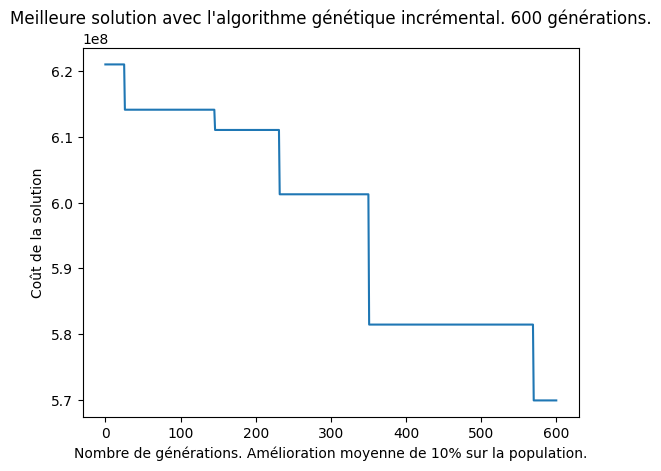

In [18]:
begin = time.time()
best_sols, best_costs, cost_amelioration_list, mean_amelioration = genetic_algorithm_incremental(population_size, mutation_incremental, df_distances, df_Tableau_Rangs, df_Vente, nb_mach, max_iter = max_iter_incremental)
elapsed_time = time.time() - begin
print(f"L'algorithme génétique nous fournit en {round(elapsed_time)} secondes plusieurs solutions intéressantes ! Voici les 3 premières:\n")

print(f'meilleure sol: {best_sols[0]}')
print(f'coût associé: {best_costs[0]}\n')

print(f'meilleure sol 2: {best_sols[1]}')
print(f'coût associé 2: {best_costs[1]}\n')

print(f'meilleure sol 3: {best_sols[2]}')
print(f'coût associé 3: {best_costs[2]}\n')

plt.plot(cost_amelioration_list)
plt.title(f"Meilleure solution avec l'algorithme génétique incrémental. {max_iter_incremental} générations.")
plt.xlabel(f"Nombre de générations. Amélioration moyenne de {mean_amelioration}% sur la population.")
plt.ylabel(f"Coût de la solution")
plt.show()

## Version générationnelle

L'algorithme génétique nous fournit en 172 secondes plusieurs solutions intéressantes ! Voici les 3 premières:

meilleure sol: {1: 20, 2: 13, 3: 11, 4: 12, 5: 1, 6: 16, 7: 27, 8: 23, 9: 18, 10: 28, 11: 19, 12: 10, 13: 25, 14: 8, 15: 26, 16: 29, 17: 9, 18: 15, 19: 24, 20: 17, 21: 14, 22: 22, 23: 21, 24: 3, 25: 2, 26: 5, 27: 4, 28: 6, 29: 7}
coût associé: 492020147

meilleure sol 2: {1: 11, 2: 13, 3: 20, 4: 12, 5: 1, 6: 16, 7: 27, 8: 23, 9: 18, 10: 28, 11: 19, 12: 10, 13: 25, 14: 8, 15: 26, 16: 29, 17: 9, 18: 15, 19: 24, 20: 17, 21: 14, 22: 22, 23: 21, 24: 3, 25: 2, 26: 5, 27: 4, 28: 6, 29: 7}
coût associé 2: 495623745

meilleure sol 3: {1: 20, 2: 13, 3: 11, 4: 12, 5: 3, 6: 16, 7: 27, 8: 22, 9: 28, 10: 19, 11: 23, 12: 10, 13: 25, 14: 8, 15: 26, 16: 29, 17: 9, 18: 15, 19: 24, 20: 17, 21: 14, 22: 18, 23: 21, 24: 1, 25: 2, 26: 5, 27: 4, 28: 6, 29: 7}
coût associé 3: 501398397



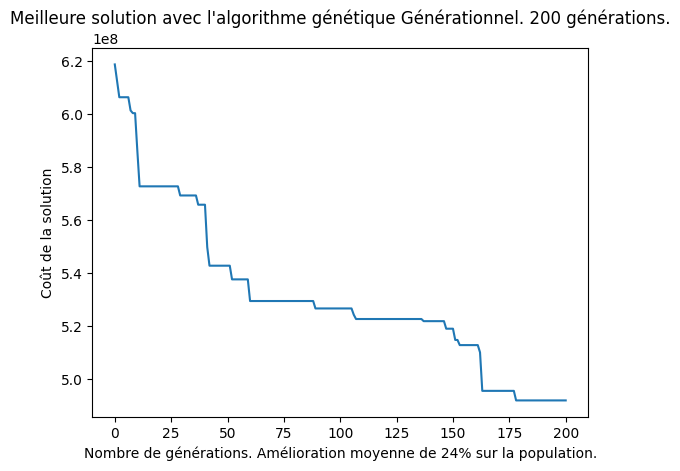

In [19]:
begin = time.time()
best_sols, best_costs, cost_amelioration_list, mean_amelioration = genetic_algorithm_generation(population_size, mutation_generationnel, df_distances, df_Tableau_Rangs, df_Vente, nb_mach, max_iter = max_iter_generationnel)
elapsed_time = time.time() - begin
print(f"L'algorithme génétique nous fournit en {round(elapsed_time)} secondes plusieurs solutions intéressantes ! Voici les 3 premières:\n")

print(f'meilleure sol: {best_sols[0]}')
print(f'coût associé: {best_costs[0]}\n')

print(f'meilleure sol 2: {best_sols[1]}')
print(f'coût associé 2: {best_costs[1]}\n')

print(f'meilleure sol 3: {best_sols[2]}')
print(f'coût associé 3: {best_costs[2]}\n')

plt.plot(cost_amelioration_list)
plt.title(f"Meilleure solution avec l'algorithme génétique Générationnel. {max_iter_generationnel} générations.")
plt.xlabel(f"Nombre de générations. Amélioration moyenne de {mean_amelioration}% sur la population.")
plt.ylabel(f"Coût de la solution")
plt.show()

## Version générationnelle hybride

L'algorithme génétique nous fournit en 211 secondes plusieurs solutions intéressantes ! Voici les 3 premières:

meilleure sol: {1: 14, 2: 4, 3: 2, 4: 17, 5: 13, 6: 19, 7: 24, 8: 25, 9: 16, 10: 12, 11: 8, 12: 6, 13: 23, 14: 26, 15: 28, 16: 3, 17: 27, 18: 1, 19: 7, 20: 9, 21: 10, 22: 22, 23: 20, 24: 11, 25: 29, 26: 15, 27: 21, 28: 5, 29: 18}
coût associé: 488033458

meilleure sol 2: {1: 26, 2: 4, 3: 12, 4: 2, 5: 13, 6: 19, 7: 24, 8: 25, 9: 16, 10: 28, 11: 8, 12: 6, 13: 23, 14: 17, 15: 14, 16: 3, 17: 27, 18: 1, 19: 7, 20: 9, 21: 10, 22: 22, 23: 20, 24: 11, 25: 29, 26: 15, 27: 21, 28: 5, 29: 18}
coût associé 2: 492331123

meilleure sol 3: {1: 14, 2: 4, 3: 2, 4: 17, 5: 13, 6: 19, 7: 24, 8: 25, 9: 16, 10: 12, 11: 8, 12: 6, 13: 23, 14: 26, 15: 28, 16: 3, 17: 27, 18: 1, 19: 7, 20: 9, 21: 10, 22: 22, 23: 20, 24: 29, 25: 11, 26: 15, 27: 21, 28: 5, 29: 18}
coût associé 3: 497271051



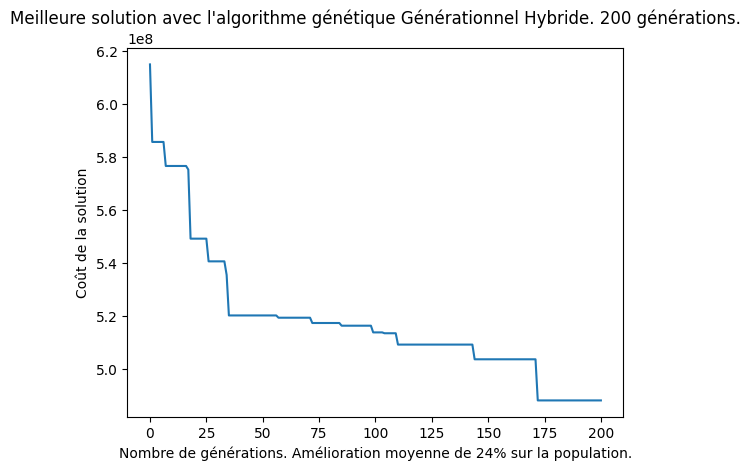

In [20]:
begin = time.time()
best_sols, best_costs, cost_amelioration_list, mean_amelioration = genetic_algorithm_generation_hybride(population_size, mutation_hybride, df_distances, df_Tableau_Rangs, df_Vente, nb_mach, max_iter = max_iter_hybride)
elapsed_time = time.time() - begin
print(f"L'algorithme génétique nous fournit en {round(elapsed_time)} secondes plusieurs solutions intéressantes ! Voici les 3 premières:\n")

print(f'meilleure sol: {best_sols[0]}')
print(f'coût associé: {best_costs[0]}\n')

print(f'meilleure sol 2: {best_sols[1]}')
print(f'coût associé 2: {best_costs[1]}\n')

print(f'meilleure sol 3: {best_sols[2]}')
print(f'coût associé 3: {best_costs[2]}\n')

plt.plot(cost_amelioration_list)
plt.title(f"Meilleure solution avec l'algorithme génétique Générationnel Hybride. {max_iter_hybride} générations.")
plt.xlabel(f"Nombre de générations. Amélioration moyenne de {mean_amelioration}% sur la population.")
plt.ylabel(f"Coût de la solution")
plt.show()

# Et sur la petite instance ?

In [21]:
# Data needed (petite instance)
df_Tableau_Rangs_PI = pandas.read_excel(os.path.abspath('Tableau_rangs.xlsx/'), index_col = 0).stack() #Tableau_Rangs est calculé grâce à la fonction donnée avec le code AMPL, "creation_Tableau_Rangs".
df_distances_PI = pandas.read_excel(os.path.abspath('Distances.xlsx/'), index_col = 0).stack()

df_Vente_PI = pandas.read_csv(os.path.abspath('Vente.txt'))
df_Vente_PI.set_index("Produits", inplace = True)

In [34]:
nb_mach_PI = 9 #pour la petite instance #nb total de machines (machine virtuelle comprise)

## pour toutes les versions
nb_solutions_PI = 400#0 #nb de solutions aléatoires à créer pour utiliser nos algorithmes de recherche (méta)heuristiques.
population_size_PI = nb_solutions_PI

## Version incrémentale
mutation_incremental_PI = 0.2
max_iter_incremental_PI = 300

## Version générationnelle
mutation_generationnel_PI = 0.05
max_iter_generationnel_PI = 100 #avec la petite instance, on peut se permettre de faire beaucoup plus de générations !

## pour l'algorithme génétique hybridé
mutation_hybride_PI = 0.05 #faible pour plus grande variété génétique de la population.
max_iter_hybride_PI = 100

L'algorithme génétique nous fournit en 99 secondes plusieurs solutions intéressantes ! Voici les 3 premières:

meilleure sol: {1: 3, 2: 4, 3: 9, 4: 8, 5: 2, 6: 6, 7: 1, 8: 7, 9: 5}
coût associé: 1335193

meilleure sol 2: {1: 3, 2: 4, 3: 9, 4: 8, 5: 5, 6: 6, 7: 1, 8: 7, 9: 2}
coût associé 2: 1337812

meilleure sol 3: {1: 3, 2: 1, 3: 4, 4: 8, 5: 2, 6: 6, 7: 9, 8: 7, 9: 5}
coût associé 3: 1358560



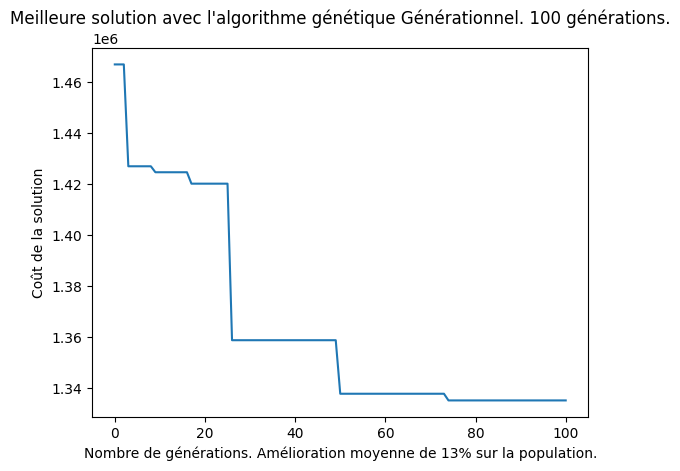

In [35]:
# Version générationnelle (NON hybride)
begin = time.time()
best_sols, best_costs, cost_amelioration_list, mean_amelioration = genetic_algorithm_generation(population_size_PI, mutation_generationnel_PI, df_distances_PI, df_Tableau_Rangs_PI, df_Vente_PI, nb_mach_PI, max_iter = max_iter_generationnel_PI)
elapsed_time = time.time() - begin
print(f"L'algorithme génétique nous fournit en {round(elapsed_time)} secondes plusieurs solutions intéressantes ! Voici les 3 premières:\n")

print(f'meilleure sol: {best_sols[0]}')
print(f'coût associé: {best_costs[0]}\n')

print(f'meilleure sol 2: {best_sols[1]}')
print(f'coût associé 2: {best_costs[1]}\n')

print(f'meilleure sol 3: {best_sols[2]}')
print(f'coût associé 3: {best_costs[2]}\n')


plt.plot(cost_amelioration_list)
plt.title(f"Meilleure solution avec l'algorithme génétique Générationnel. {max_iter_generationnel_PI} générations.")
plt.xlabel(f"Nombre de générations. Amélioration moyenne de {mean_amelioration}% sur la population.")
plt.ylabel(f"Coût de la solution")
plt.show()

L'algorithme génétique nous fournit en 169 secondes plusieurs solutions intéressantes ! Voici les 3 premières:

meilleure sol: {1: 3, 2: 4, 3: 9, 4: 8, 5: 2, 6: 6, 7: 1, 8: 7, 9: 5}
coût associé: 1335193

meilleure sol 2: {1: 3, 2: 4, 3: 9, 4: 8, 5: 5, 6: 6, 7: 1, 8: 7, 9: 2}
coût associé 2: 1337812

meilleure sol 3: {1: 6, 2: 8, 3: 2, 4: 1, 5: 9, 6: 4, 7: 5, 8: 7, 9: 3}
coût associé 3: 1358109



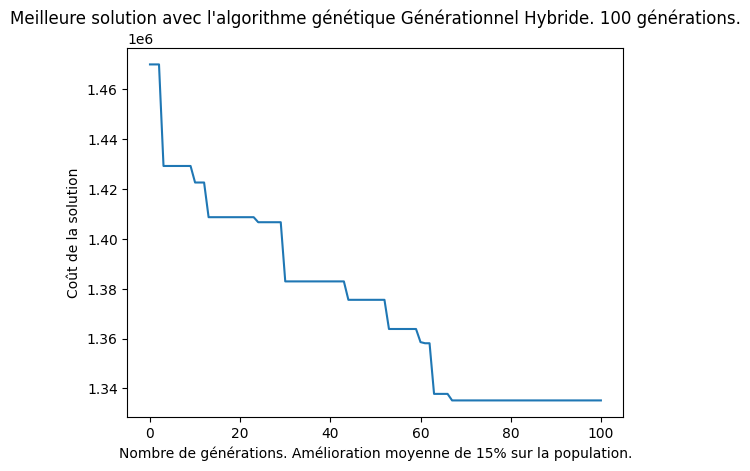

In [36]:
# Version générationnelle hybride:
begin = time.time()
best_sols, best_costs, cost_amelioration_list, mean_amelioration = genetic_algorithm_generation_hybride(population_size_PI, mutation_hybride_PI, df_distances_PI, df_Tableau_Rangs_PI, df_Vente_PI, nb_mach_PI, max_iter = max_iter_hybride_PI)
elapsed_time = time.time() - begin
print(f"L'algorithme génétique nous fournit en {round(elapsed_time)} secondes plusieurs solutions intéressantes ! Voici les 3 premières:\n")

print(f'meilleure sol: {best_sols[0]}')
print(f'coût associé: {best_costs[0]}\n')

print(f'meilleure sol 2: {best_sols[1]}')
print(f'coût associé 2: {best_costs[1]}\n')

print(f'meilleure sol 3: {best_sols[2]}')
print(f'coût associé 3: {best_costs[2]}\n')

plt.plot(cost_amelioration_list)
plt.title(f"Meilleure solution avec l'algorithme génétique Générationnel Hybride. {max_iter_hybride_PI} générations.")
plt.xlabel(f"Nombre de générations. Amélioration moyenne de {mean_amelioration}% sur la population.")
plt.ylabel(f"Coût de la solution")
plt.show()

In [39]:
cout_total({1:3, 2:4, 3:9, 4:8, 5:2, 7:1, 6:6, 8:7, 9:5}, df_distances_PI,df_Tableau_Rangs_PI,df_Vente_PI)

1335193